## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This reports aims to analyse the conversion data from a website. Several statistical analyses are used to determine whether a new page design results in more conversions, thus allowing for an advise on the new page design. The analysis consists of descriptive statistics regarding the initial data followed by an A/B test and regression analysis. The regression analysis allows for confirmation of the A/B test results and for the addition of variables into the analysis

<a id='probability'></a>
#### Part I - Probability

firstly import the libraries and the dataset.

In [77]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [78]:
df_ab = pd.read_csv("ab_data.csv")
#show excerpt of dataset to check for succes
df_ab.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Having imported the dataset, the general characteristics of the data are displayed below

In [79]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


from this we can extract the following metrics:
*unique users:*

In [80]:
print("the number of unique users: %i " %df_ab["user_id"].nunique())

the number of unique users: 290584 


*the average conversion rate*

In [81]:
print('the average conversion rate: %f ' %df_ab['converted'].mean())

the average conversion rate: 0.119659 


It is clear from the excerpt shown above, that there is a connection between the `group` and `landing_page` columns. If the landing page is `old_page`, the user should be in the group `control`. Therefore it is prudent to check if this is indeed the case for all rows in the data. 

In [82]:
#counting all instances where the landing page is 'new-page' AND group is 'control' and adding this to instances where 'old_page' is in group 'treatment'
df_ab.query('landing_page =="new_page" and group == "control" ').count()[0] + df_ab.query('landing_page =="old_page" and group == "treatment" ').count()[0]


3893

There are 3893 cases, where the landing page does not match the correct group. For these cases it cannot be ascertained which `landing_page` was presented to them. The data is thus unreliable, and these rows are to be deleted. For the sake of efficiency a check on missing values is also performed. The rows with missing values can then be deleted simultaniously.
f. Do any of the rows have missing values?

In [83]:
#checking for missing values
df_ab.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Since only the rows with unmatchinig *page* and *treatment* values are to be deleted, it is most efficient to compute a new DataFrame specifying the correct relation between `landing_page` and `group`.

In [84]:
#creating a new dataframe
df2 = df_ab.query('(landing_page == "new_page" and group == "treatment") or (landing_page == "old_page" and group == "control")')

In [85]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

With the dataset cleaned, we can continue descriptions of the dataset, first of all checking for all unique users in the dataset, and potential duplications in the data

In [86]:
#counting all unqiue user id's
df2.user_id.nunique()

290584

In [87]:
#displaying the duplicated rows
print(df2[df2.duplicated('user_id')])

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


There are no further anomolies with the duplicated user, which means this row can be dropped without consequence.

In [88]:
#drop the duplicated user ID based on the index
df2.drop(index = 2893, inplace = True)

C:\Users\lpede\anaconda3\envs\nanodegree\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [89]:
#check whether the total number of unique user id's has changed.
df2.user_id.nunique()

290584

In [90]:
#check if there are only unique users in the dataset by comparing the number of unique user id's to the total nr of records
len(df2)

290584

since the total number of records is equal to the nr of unique user id's, we don't need to implement a filter on unique user id's going forward.

The general statistics of the dataset can be extracted from `df2` going forward. Since the goal of this report is to determine if the new page leads to more conversions the following statistics are determined:  
`1` the general conversion rate  
`2` the conversion rate for the control group  
`3` the conversion rate for the treatment group  
`4` The chance of being in the treatment group for a new user  
`5` The difference in conversion rates between the control and treatment group

In [91]:
#general vonersion rate, stored for future use
p = df2.converted.mean()
p

0.11959708724499628

In [92]:
#the conversion rate for the control group, stored for future use
p_control = df2.query('group == "control"').converted.mean()
p_control

0.1203863045004612

In [93]:
#the conversion rate for the treatment group, stored for future use
p_treatment = df2.query('group == "treatment"').converted.mean()
p_treatment

0.11880806551510564

In [94]:
#the chance of recieving a new_page, and thus being in the treatment group.
df2[df2['landing_page']== 'new_page'].count()[0]/df2.count()[0]

0.5000619442226688

In [95]:
#the difference in conversion rates between the treatment and control group.
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

**Given that the observed difference in conversions between the new page and old page is negative, it would not be prudent to state that the new page leads to more conversions. What is observed here is that the old page has more conversions than the new one. As the total number of users is fairly large with 290000 and the ratio of showing the old page vs new is 50/50, the above observation holds.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


First tests include an hypothesis test at a Type I error rate of 5%. The hypotheses are stated in terms of **$p_{old}$** and **$p_{new}$** . 

**$H_{0}$ : $p_{old} - p_{new} >= 0 $**     

**$H_{1}$ : $p_{old} - p_{new} < 0 $**      

In order to test on a singe value, the initial assumption is that under the null hypothesis $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. This is the value previously saved under `p`. <br><br>

In order to test this we simulate samples on a normal distribution assumping `p`, with a sample size equal to **ab_data.csv** and with replacement.  <br><br>

From this we generate a sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>
The conversion rate `p_new` under the null is the conversion rate as it can be extracted from the dataset. The assumption in this part of the analysis is, that there is **no** difference between the new page or the old page. Therefore we can take the total conversion rate observed in the dataset as the `p_new` **and** as `p_old`.

In [96]:
# under the null hypothesis P_new and p_old are the same
p_new = df2.converted.mean()
p_old = df2.converted.mean()

in order to find the conversion rates we need the total nr of users in the different groups

In [97]:
#nr of users in the Treatment group
n_new = df2[df2['group']=="treatment"].user_id.nunique()
n_new

145310

In [98]:
#nr of users in the control group
n_old = df2[df2['group']== "control"].user_id.nunique()
n_old

145274

In order to test whether or not the difference between the conversion rates `p_new` and `p_old` is indeed 0 (as the null hypothesis states), we simulate a random series of conversions, assuming the `p_new` as the chance of conversion from a binomial distribution. As we do the same for `p_old`, the difference between these two distributions should give us a good idea what this difference would be **if** the null hypothesis hold strue. We store the results under `new_page_converted` and `old_page_converted`, and storing the difference between the means of these two arrays under `p_diff_null`.

In [99]:
new_page_converted = np.random.binomial(1,p_new, n_new)
new_page_converted

array([1, 0, 0, ..., 1, 0, 0])

In [100]:
old_page_converted = np.random.binomial(1,p_old,n_old)

In [101]:
p_diff_null = old_page_converted.mean()-new_page_converted.mean()
p_diff_null

0.0023282741489399073

We see from the above simulation that the statistics give a small difference between old and new page conversion rates (`p_diff_null`), this is consistent with the difference found in the data (`obs_diff`). In order to see if we can expect a difference of 0 or larger in most cases, we simulate 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process and store these values in `p_diffs`. Plotting the values in `p_diffs` can give us a visual of the distribution while providing a basis for a z-test.

In [102]:
#the empty list, to be filled by the for loop
p_diffs = []
#for loop, iterating the simulation of conversions, and adding the resulting difference in conversion ratios to the list.
for _ in range(10000):
    npc = np.random.binomial(1,p_new, n_new)
    opc = np.random.binomial(1,p_old,n_old)
    pdiff = opc.mean()-npc.mean()
    p_diffs.append(pdiff)

A histogram of `p_diffs` should show a normal distribution, by indicating the location of the observed difference in the data `obs_diff` in the histogram we can see where it falls in the distribution.

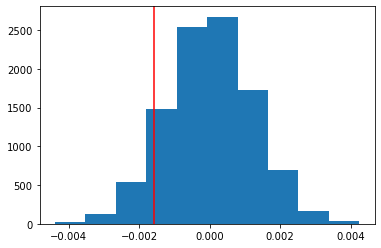

In [103]:
plt.hist(p_diffs);
plt.axvline(x= obs_diff, color = 'red' )

As the null hypothesis states that the difference between old and new page conversion rates is 0 or larger then zero, we are interested in the proportion of values from our simulation that confirm the null hypothesis. 

In [104]:
#proportion of values in line with the null hypothesis.
prop = (p_diffs > obs_diff).mean()
prop

0.9036

**The null hypothesis states: we expect the difference between conversions with the old page and the new page are larger or equal to one. We see that the proportion of simulated behaviours in the null hypothesis, that are indeed larger than the observed difference is 90%. This means that we have no grounds for rejecting the null hypothesis.** 

The same procedure is also coded in the statsmodels module. Performing a z-test will also give us a value for the proportion in line with the null hypothesis. 

In [105]:
#importing statsmodels
import statsmodels.api as sm

#number of conversions from the old page
convert_old = len(df2.query('landing_page == "old_page" and converted == 1'))
#number of conversions from the new page
convert_new = len(df2.query('landing_page == "new_page" and converted == 1'))
#nr of total users on old page
n_old = len(df2.query('landing_page == "old_page"'))
#nr of total users on new page
n_new = len(df2.query('landing_page == "new_page"'))

In [106]:
#defining the required statistics and giving the inputs
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative = 'larger')
z_score,p_value

(-1.3109241984234394, 0.9050583127590245)

**The z-score indicates the number of standard deviatons that our observed value is removed from the expected mean under a normal distribution. We see that our observed value is 1.3 standard deviations removed, which is within the 95% confidence interval demanded by the $\alpha$ of 0.05. The p_value, indicates the chance of finding a value consistent with the null hypothesis, at 0.90 it is larger than the $\alpha$. Therefore there is, as was with the previous method no grounds for rejecting the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

A regression analysis can provide further confirmation and allows for the addition of factors in the analysis. Since each row is either a conversion or no conversion, a logistical regression model is used, including a dummy variable expressing the landing page as a 0 for the old page and a 1 for the new page.

The module **statsmodels** is used to fit a logistical regression model to see if there is a significant difference in conversion based on which page a customer receives. To do this an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control** is added. 

In [107]:
pd

<module 'pandas' from 'C:\\Users\\lpede\\anaconda3\\envs\\nanodegree\\lib\\site-packages\\pandas\\__init__.py'>

In [108]:
#creating the intercept columns
df2['intercept'] = 1
#creating new colums for control and treatment and populating them with dummy values
df2[['control','treatment']] = pd.get_dummies(df2['group'])
#drop one of the columns, since only one column can be used for the regeression analysis.
df2.drop('control', axis = 1, inplace = True)
#rename the column to 'ab_page'
df2.rename(columns = {'treatment': 'ab_page'}, inplace = True)
#check for results
df2.head()

<ipython-input-108-da402c208e87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1
C:\Users\lpede\anaconda3\envs\nanodegree\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\lpede\anaconda3\envs\nanodegree\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**statsmodels** is used to instantiate your regression model on the two columns created above, then fitted to predict the conversion. 

In [109]:
mod = sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Nov 2020   Pseudo R-squ.:               8.077e-06
Time:                        17:00:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [110]:
#calculating the exponent and the inversion as expression of the product increase in chances for conversions
np.exp(-0.0150), 1/np.exp(-0.0150)

(0.9851119396030626, 1.015113064615719)

**The A/B-test performed earlier, supposes direction in the results. i.e the null hypothesis and alternative are postulated as being equal or greater then or smaller then 0:** 

**$H_{0}$ : $p_{old} - p_{new} >= 0 $**     

**$H_{1}$ : $p_{old} - p_{new} < 0 $**     

**In a logistical regression analysis , there is no direction proposed, since the model only observes two possible outcomes. Therefore the either the variable affects the outcome or it does not. The null hypothisis is that the chance of succes (meaning conversion) is equal between the old and new page, there is no relation between the page and the conversion rate. 
so the null hypothesis in the logistic regression model is:**

**$H_{0}$ : $p_{old} = p_{new}$**  
**$H_{1}$ : $p_{conversion} \neq 0$**

**the p-value for the logistic model is 0.190, well above 0.05 offering no grounds to reject the null hypothesis. This p-value is larger then the p-value found using the z-test, which was 0.09. This is because the z-tests includes a directional component, reducing the surface of the distribution monitored. However both tests conclude that the null hypothesis should not be rejected.

Adding additional terms might offer further explenaition for the result. However if additional terms are correlated to each other they will interfere with the results. it is therefore important to check any additional terms for multicollinearity. The terms available at the moment are the page that the user lands on, the group they are placed in and their user_id. As is concluded in the introduction to this report, the landing page and group are closely correlated. Since we already utelise the group in our model, adding the landing page, will not improve the prediction. The user_id contains no further information and will also add little to the analysis. 

From each user, the country of residence is available in a seperate dataset. This information may prove to add to our analysis.

In [111]:
#read in the country data
dfc= pd.read_csv('countries.csv')
#view format of the DataFrame
dfc.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Since both the `dfc` and `df2` dataframes utelise user_id's the two dataframes can be joined on this column. 

In [112]:
#joining the dataframes
df2_join = df2.join(dfc.set_index('user_id'), on = 'user_id')
#check for results
df2_join.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In order to fit a logistical regression model on the data on countries, dummy variables need to be introduced to the dataframe. First of the unique countries present in the dataset are identified:

In [113]:
dfc['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

Three countries are present in the dataset. Below a column is created for each country populated by a dummy variable.

In [114]:
df2_join[['CA','UK','US']] = pd.get_dummies(df2_join['country'])
df2_join.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [115]:
#fitting the logistical regression model, utilising two of the three countries to prevent multicollinearity
mod = sm.Logit(df2_join['converted'],df2_join[['intercept','ab_page','US','CA']])
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 17 Nov 2020   Pseudo R-squ.:               2.323e-05
Time:                        17:00:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

The above results show that the country, whether the baseline UK or the US or Canada, no statistical difference in the conversion is shown. P values are higher then 0.05 at **0.457** and **0.074** respectively for the US and Canada. It could be possible that there is an interaction between the countries and ab_page. If this is the case we should see differences in the p values, when adding interaction terms for the countries to the model.

In [116]:
#calculating the interaction terms
df2_join["ab_page_us"] = df2_join["US"]*df2_join['ab_page']
df2_join["ab_page_uk"] = df2_join["UK"]*df2_join['ab_page']
df2_join["ab_page_ca"] = df2_join["CA"]*df2_join['ab_page']

In [117]:
#creating the new model and fitting
mod = sm.Logit(df2_join['converted'],df2_join[['intercept','ab_page','US','CA','ab_page_uk','ab_page_ca']])
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 17 Nov 2020   Pseudo R-squ.:               3.482e-05
Time:                        17:00:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
ab_page_uk     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page_ca    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

The above analysis shows, no statistical significance in the potential interaction terms. Therefore it can be said that there is no interaction between the countries and the conversion rates. This means that the results of our previous analysis can be applied irregardless of the country of origen of the user.

<a id='conclusions'></a>
# Conclusions

After performing an A/B test, z-test and logistic regression analysis, all results point towards upholding the null hypothesis. This hypothesis being that **there is no improvement to be gained from the new page in terms of conversions made**.

The addition of country of origen of the users has not altered this result, and the analysis utilising interaction terms shows that there is no interaction between the countries of origin and the conversion rate. Thus country of origin has no significant effect on the conversion rate. 

In the logistic regression analysis a product decrease in the chance of conversion with the old page of *1.02* has been found. This result was statistically not significant, but also from a practical standpoint, with such a minor difference no benefit or harm can be found. Per example the general conversion rate `p` was *0.119*. A *1.02* decrease would come to *0.117* conversion rate. 

The overall conclusion must be that, from the data presented,  there is no reason to move forward with the new design.
